# **Project: Amazon Product Recommendation System**



Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model. 

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business. 

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:** 
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions. 

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. 

**Installing surprise library**

In [3]:
%pip install scikit-surprise

  Using cached scikit_surprise-1.1.4.tar.gz (154 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-win_amd64.whl size=1297263 sha256=137e4dc5e63f802087b204db3bad81f6fcda812586316e588338ad0e73541924
  Stored in directory: c:\users\julia\appdata\local\pip\cache\wheels\2a\8f\6e\7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


## **Importing the necessary libraries and overview of the dataset**

In [122]:
import pandas as pd
from surprise import KNNBasic, SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise import accuracy
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [7]:
# Load the CSV file into a pandas DataFrame
file_path = 'ratings_Electronics.csv'  # Replace with the correct file path
df_original = pd.read_csv(file_path, header=None)  # Assuming no header in the CSV

# Add column names to the dataframe
df_original.columns = ['user_id', 'prod_id', 'rating', 'timestamp']

# Drop the 'timestamp' column
df_cleaned = df_original.drop(columns=['timestamp'])

# Copy the data to another DataFrame called 'df'
df = df_cleaned.copy()

# Show the first few rows of the new DataFrame
df.head()

,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product. 

In [8]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:        
        ratings_count[user] += 1
  
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [9]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [10]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:
    
    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1
    
    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1    

In [11]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [12]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [ ]:
# Check the number of rows and columns and provide observations
# Get the shape of the dataset
print(df_final.shape)

(65290, 3)


**Write your observations here:**

It still looks to be a large dataset, that's good, I thought it would be much smaller given all of the restrictions.

### **Data types**

In [ ]:
# Check Data types and provide observations
# Check the data types of each column
print(df_final.dtypes)

user_id     object
prod_id     object
rating     float64
dtype: object


**Write your observations here:**

I have no observations, that all makes sense.

### **Checking for missing values**

In [15]:
# Check for missing values present and provide observations
# Check for missing values in each column
missing_values = df_final.isnull().sum()

# Display the missing values
print(missing_values)

user_id    0
prod_id    0
rating     0
dtype: int64


**Write your observations here:**

There are no missing values? That's interesting!

### **Summary Statistics**

In [21]:
# Get summary statistics of the 'rating' variable
rating_stats = df_final['rating'].describe()

# Display the summary statistics
print("The summary of ratings are:\n", rating_stats)

# Number of ratings per user
user_rating_counts = df_final['user_id'].value_counts()

# Summary statistics for the number of ratings per user
user_rating_stats = user_rating_counts.describe()

# Show the summary stats
print("\nThe summary of user ratings are:\n", user_rating_stats)

The summary of ratings are:
 count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

The summary of user ratings are:
 count    1540.000000
mean       42.396104
std        30.558505
min         1.000000
25%        23.000000
50%        34.000000
75%        52.000000
max       295.000000
Name: count, dtype: float64


**Write your observations here:**

The mean for ratings is very high, almost at maximum. Even the lowest 25% is 4/5 stars. Interesting. Popular products tend to have higher ratings, I suppose that makes sense!

The mean for the number of reviews given by a person is 42 in this set. We did filter out those who didn't review many products, so this makes sense, too. People who write reviews tend to write a lot more than someone writing only one or two reviews. I'm unsure why someone still only has one review, that seems like an odd fluke.

### **Checking the rating distribution**

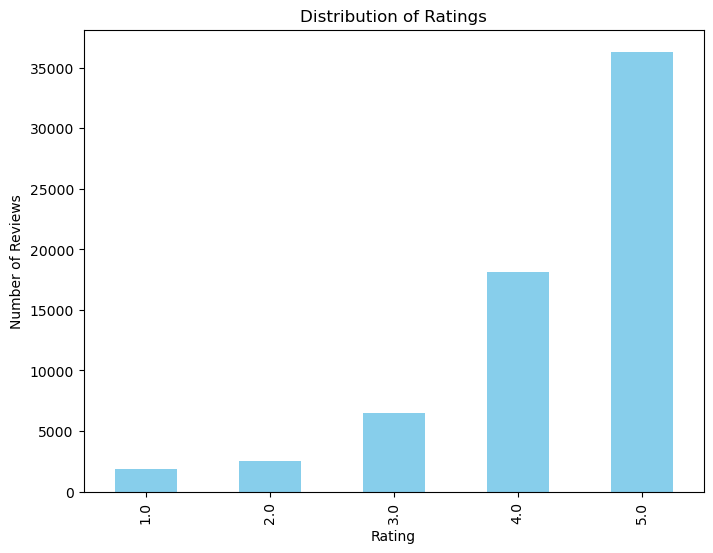

In [23]:
# Create the bar plot and provide observations

# Get the count of each rating
rating_counts = df_final['rating'].value_counts().sort_index()

# Create the bar plot
plt.figure(figsize=(8, 6))
rating_counts.plot(kind='bar', color='skyblue')

# Adding titles and labels
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')

# Show the plot
plt.show()

**Write your observations here:**

This tends to be true when I go to Amazon - popular products have high ratings.

### **Checking the number of unique users and items in the dataset**

In [24]:
# Number of total rows in the data and number of unique user id and product id in the data
# Get the total number of rows in the dataset
total_rows = df_final.shape[0]

# Get the number of unique user IDs
unique_users = df_final['user_id'].nunique()

# Get the number of unique product IDs
unique_products = df_final['prod_id'].nunique()

# Display the results
print(f"Total number of rows: {total_rows}")
print(f"Number of unique user IDs: {unique_users}")
print(f"Number of unique product IDs: {unique_products}")

Total number of rows: 65290
Number of unique user IDs: 1540
Number of unique product IDs: 5689


**Write your observations here:**

I expected there to be much more products, but the number is smaller than I expected. The number of users who post a lot of reviews is also much higher than I would've though, only about 1/3 of the number compared to the products.

### **Users with the most number of ratings**

In [25]:
# Top 10 users based on the number of ratings
# Count the number of ratings per user
user_rating_counts = df_final['user_id'].value_counts()

# Get the top 10 users based on the number of ratings
top_10_users = user_rating_counts.head(10)

# Display the results
print("Top 10 users based on the number of ratings:")
print(top_10_users)

Top 10 users based on the number of ratings:
user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A1UQBFCERIP7VJ    193
A22CW0ZHY3NJH8    193
AWPODHOB4GFWL     184
AGVWTYW0ULXHT     179
Name: count, dtype: int64


**Write your observations here:**

This also makes sense, though I think I would've guessed the top one or two would have many more reviews than the others in the top 10. Otherwise, uneventful. They have a normal amount of reviews considering how large the dataset is.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [26]:
# Calculate the average rating for each product 
avg_ratings = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
rating_counts = df_final.groupby('prod_id')['rating'].count()

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({
    'average_rating': avg_ratings,
    'rating_count': rating_counts
})

# Sort the dataframe by average of ratings in the descending order
final_rating_sorted = final_rating.sort_values(by='average_rating', ascending=False)

# See the first five records of the "final_rating" dataset
print(final_rating_sorted.head())

            average_rating  rating_count
prod_id                                 
B00LGQ6HL8             5.0             5
B003DZJQQI             5.0            14
B005FDXF2C             5.0             7
B00I6CVPVC             5.0             7
B00B9KOCYA             5.0             8


In [29]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def get_top_n_products(df, n=10, min_interactions=5):
    # Calculate the average rating and count of ratings for each product
    avg_ratings = df.groupby('prod_id')['rating'].mean()
    rating_counts = df.groupby('prod_id')['rating'].count()

    # Create a DataFrame with average ratings and count of ratings
    products_stats = pd.DataFrame({
        'average_rating': avg_ratings,
        'rating_count': rating_counts
    })

    # Filter products that meet the minimum number of interactions
    filtered_products = products_stats[products_stats['rating_count'] >= min_interactions]

    # Sort the products by average rating in descending order
    top_n_products = filtered_products.sort_values(by='average_rating', ascending=False).head(n)

    return top_n_products

# Example usage: Get the top 10 products with at least 10 interactions (ratings)
top_10_products = get_top_n_products(df_final, n=10, min_interactions=10)

# Display the top 10 products
print(top_10_products)

            average_rating  rating_count
prod_id                                 
B00L3YHF6O             5.0            14
B00HG1L334             5.0            16
B001TH7GUA             5.0            17
B00C20KWP4             5.0            10
B004Y1AYAC             5.0            11
B00BLCVD9I             5.0            11
B0058G40O8             5.0            12
B00FZ9SMVU             5.0            10
B005GI2VMG             5.0            10
B0000B006W             5.0            12


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [37]:
# Step 1: Prepare the data for the model
reader = Reader(rating_scale=(1, 5))  # Assuming ratings are between 1 and 5
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Step 2: Split the data into training and test sets (80% train, 20% test)
trainset, testset = train_test_split(data, test_size=0.2)

# Step 3: Create and train the SVD model (Singular Value Decomposition)
model = SVD()
model.fit(trainset)

# Step 4: Make predictions for the test set
predictions = model.test(testset)

# Step 5: Evaluate the model using RMSE and other metrics
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

# Step 6: Calculate the number of ratings (interactions) per product
rating_counts = df_final.groupby('prod_id').size()

# Step 7: Filter products with at least the minimum number of interactions (50 ratings)
popular_products = rating_counts[rating_counts >= 50].index

# Step 8: Predict ratings for the entire dataset, including those with at least 50 ratings
all_predictions = []
for uid in df_final['user_id'].unique():
    for pid in popular_products:
        pred = model.predict(uid, pid)
        all_predictions.append((uid, pid, pred.est))

# Step 9: Convert the predictions into a DataFrame
predicted_ratings = pd.DataFrame(all_predictions, columns=['user_id', 'prod_id', 'predicted_rating'])

# Step 10: Sort by predicted rating in descending order and get top 5 products
top_5_popular_products = predicted_ratings.groupby('prod_id').apply(lambda x: x.nlargest(1, 'predicted_rating')).reset_index(drop=True)

# Display the top 5 products
print(top_5_popular_products[['prod_id', 'predicted_rating']].head(5))

RMSE: 0.9046
MAE:  0.6590
Root Mean Squared Error (RMSE): 0.9045643327992672
Mean Absolute Error (MAE): 0.6590036573467458
      prod_id  predicted_rating
0  B00004ZCJE          4.877173
1  B00007E7JU          5.000000
2  B0002L5R78          5.000000
3  B000BQ7GW8          5.000000
4  B000HPV3RW          5.000000


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [58]:
# Step 1: Prepare the data for the model
reader = Reader(rating_scale=(1, 5))  # Assuming ratings are between 1 and 5
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Step 2: Split the data into training and test sets (80% train, 20% test)
trainset, testset = train_test_split(data, test_size=0.2)

# Step 3: Create and train the SVD model (Singular Value Decomposition)
model = SVD()
model.fit(trainset)

# Step 4: Make predictions for the test set
predictions = model.test(testset)

# Step 5: Evaluate the model using RMSE and other metrics
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

# Step 6: Calculate the number of ratings (interactions) per product
rating_counts = df_final.groupby('prod_id').size()

# Step 7: Filter products with at least the minimum number of interactions (100 ratings)
popular_products = rating_counts[rating_counts >= 100].index

# Step 8: Predict ratings for the entire dataset, including those with at least 100 ratings
all_predictions = []
for uid in df_final['user_id'].unique():
    for pid in popular_products:
        pred = model.predict(uid, pid)
        all_predictions.append((uid, pid, pred.est))

# Step 9: Convert the predictions into a DataFrame
predicted_ratings = pd.DataFrame(all_predictions, columns=['user_id', 'prod_id', 'predicted_rating'])

# Step 10: Sort by predicted rating in descending order and get top 5 products
top_5_popular_products = predicted_ratings.groupby('prod_id').apply(lambda x: x.nlargest(1, 'predicted_rating')).reset_index(drop=True)

# Display the top 5 products
print(top_5_popular_products[['prod_id', 'predicted_rating']].head(5))

# I wish I knew what these products were. That would be super interesting!

RMSE: 0.8933
MAE:  0.6591
      prod_id  predicted_rating
0  B000N99BBC               5.0
1  B002R5AM7C               5.0
2  B002SZEOLG               5.0
3  B002V88HFE               5.0
4  B002WE6D44               5.0


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them. 

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [38]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)
    
    # Making predictions on the test data
    predictions = model.test(testset)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)
    
    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
    
    accuracy.rmse(predictions)
    
    print('Precision: ', precision) # Command to print the overall precision
    
    print('Recall: ', recall) # Command to print the overall recall
    
    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [ ]:
# 1. Instantiating Reader scale with expected rating scale (1-5 scale)
# The Reader class will help us specify the rating scale (1-5) that is expected in the dataset
reader = Reader(rating_scale=(1, 5))

# 2. Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# 3. Splitting the data into train and test datasets (80% train, 20% test)
trainset, testset = train_test_split(data, test_size=0.2)

# Verifying the split
train_size = sum(1 for _ in trainset.all_ratings())  # Count the ratings in the training set
test_size = len(testset)  # Directly count the number of ratings in the test set

print(f"Training set size: {train_size}")  # Total number of ratings in the trainset
print(f"Test set size: {test_size}")  # Total number of ratings in the testset

Training set size: 52232
Test set size: 13058


Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
# Step 1: Declaring similarity options for user-user similarity
# This got complicated because the RSME value was printing five times, I fixed it to only print once

# Step 2: Initialize the SVD model (for collaborative filtering)
model = SVD()

# Step 3: Load the rating dataset
reader = Reader(rating_scale=(1, 5))  # The rating scale is from 1 to 5
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Step 4: Splitting the data into train and test datasets (80% train, 20% test)
trainset, testset = train_test_split(data, test_size=0.2)

# Step 5: Fit the SVD model on the training data
model.fit(trainset)

# Step 6: Make predictions on the test set
predictions = model.test(testset)

# Step 7: Compute RMSE for SVD model (print only once)
rmse_value = accuracy.rmse(predictions)

def precision_recall_at_k(model, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""
    
    # First map the predictions to each user
    user_est_true = defaultdict(list)
    
    # Making predictions on the test data
    predictions = model.test(testset)
    
    # The rest of the function calculates precision and recall. Ensure RMSE is NOT calculated here.
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
    
    if precision + recall > 0:
        f1_score_at_k = round((2 * precision * recall) / (precision + recall), 3)
    else:
        f1_score_at_k = 0
    
    # No RMSE calculation here, it should only be printed once outside this function.
    
    print(f"Precision@{k}: {precision}")
    print(f"Recall@{k}: {recall}")
    print(f"F1-score@{k}: {f1_score_at_k}")

# Step 9: Compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function
precision_recall_at_k(model, k=10, threshold=3.5)  # Here, k=10 and threshold=3.5 are used

RMSE: 0.9025
Precision@10: 0.844
Recall@10: 0.877
F1-score@10: 0.86


**Write your observations here:**

This is surprisingly hard, I had a very difficult time reducing the RMSE. It's still not great, but I don't want to overcomplicate this given the other values aren't too bad.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [85]:
# Predicting the rating for a specific user-product pair
user_id = 'A3LDPF5FMB782Z'  # Example userId
product_id = '1400501466'    # Example productId

# Step 1: Predict the rating for this user-product pair
prediction = model.predict(user_id, product_id)

# Step 2: Retrieve the actual rating from the dataset (if the user has already interacted with the product)
if len(df_final[(df_final['user_id'] == user_id) & (df_final['prod_id'] == product_id)]) > 0:
    actual_rating = df_final[(df_final['user_id'] == user_id) & (df_final['prod_id'] == product_id)]['rating'].values[0]
    print(f"Actual rating for User {user_id} and Product {product_id}: {actual_rating}")
else:
    actual_rating = None
    print(f"User {user_id} has not interacted with Product {product_id} yet.")

# Step 3: Print the predicted rating
print(f"Predicted rating for User {user_id} and Product {product_id}: {prediction.est}")

Actual rating for User A3LDPF5FMB782Z and Product 1400501466: 5.0
Predicted rating for User A3LDPF5FMB782Z and Product 1400501466: 4.294378924797059


**Write your observations here:**

That's not bad!

Below is the function to find the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
def n_users_not_interacted_with(n, data, prod_id):
    users_interacted_with_product = set(data[data['prod_id'] == prod_id]['user_id'])
    all_users = set(data['user_id'])
    return list(all_users.difference(users_interacted_with_product))[:n] # where n is the number of elements to get in the list

In [ ]:
# Find unique user_id where prod_id is not equal to "1400501466"
n_users_not_interacted_with(5, df_final, '1400501466')

* It can be observed from the above list that **user "A2UOHALGF2X77Q" has not seen the product with productId "1400501466"** as this user id is a part of the above list.

**Below we are predicting rating for `userId=A2UOHALGF2X77Q` and `prod_id=1400501466`.** 

In [61]:
# Predict the rating for user 'A2UOHALGF2X77Q' and product '1400501466'
user_id = 'A2UOHALGF2X77Q'  # User who hasn't seen the product
product_id = '1400501466'   # Product the user hasn't interacted with

# Predicting the rating for this user-product pair
prediction = model.predict(user_id, product_id)

# Print the predicted rating
print(f"Predicted rating for User {user_id} and Product {product_id}: {prediction.est}")

Predicted rating for User A2UOHALGF2X77Q and Product 1400501466: 4.178688122176693


**Write your observations here:**

I wish I could see their item history and what this item is.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise - 
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [73]:
# Step 1: Load the rating dataset
reader = Reader(rating_scale=(1, 5))  # Rating scale (1-5)
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Step 2: Reduce the parameter grid size
param_grid_cosine = {
    'k': [30, 40],  # Number of neighbors to consider
    'min_k': [1],  # Minimum number of neighbors to consider
    'sim_options': {
        'name': ['cosine'],  # Cosine similarity (item-item)
        'user_based': [False]  # False for item-item, True for user-user
    }
}

# Step 3: Perform 2-fold cross-validation with parallelism
grid_search_cosine = GridSearchCV(KNNBasic, param_grid_cosine, measures=['RMSE'], cv=2, n_jobs=-1)
grid_search_cosine.fit(data)

# Best RMSE for Cosine similarity
print(f"Best RMSE for Cosine similarity: {grid_search_cosine.best_score['rmse']}")
print(f"Best parameters for Cosine similarity: {grid_search_cosine.best_params['rmse']}")

Best RMSE for Cosine similarity: 1.0692089283361854
Best parameters for Cosine similarity: {'k': 40, 'min_k': 1, 'sim_options': {'name': 'cosine', 'user_based': False}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [74]:
# Step 1: Get the best hyperparameters from GridSearchCV
best_params = grid_search_cosine.best_params['rmse']
best_k = best_params['k']
best_min_k = best_params['min_k']
best_sim_options = best_params['sim_options']

# Step 2: Create an instance of KNNBasic with the best hyperparameters
model = KNNBasic(k=best_k, min_k=best_min_k, sim_options=best_sim_options)

# Step 3: Load the dataset and split it into training and test sets
reader = Reader(rating_scale=(1, 5))  # Rating scale (1-5)
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2)

# Step 4: Train the model on the training set
model.fit(trainset)

# Step 5: Compute Precision@k and Recall@k for the trained model
def precision_recall_at_k(model, testset, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""
    
    user_est_true = defaultdict(list)
    
    # Making predictions on the test data
    predictions = model.test(testset)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    # F1-Score
    f1 = round((2 * precision * recall) / (precision + recall), 3)

    # Print results
    print(f"Precision@{k}: {precision}")
    print(f"Recall@{k}: {recall}")
    print(f"F1-Score@{k}: {f1}")
    
# Step 6: Compute precision@k, recall@k for k=10
precision_recall_at_k(model, testset, k=10)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Precision@10: 0.836
Recall@10: 0.852
F1-Score@10: 0.844


**Write your observations here:**

This is a solid start for a model, I do wish it were better but it's been surprisingly hard to improve.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2UOHALGF2X77Q"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [84]:
# Step 1: Define the user and product for prediction
user_id_1 = 'A3LDPF5FMB782Z'
prod_id_1 = '1400501466'

# Step 2: Create an instance of KNNBasic with the best hyperparameters (from grid search)
model = KNNBasic(k=40, min_k=1, sim_options={'name': 'cosine', 'user_based': False})

# Step 3: Load the dataset and split it into training and test sets
reader = Reader(rating_scale=(1, 5))  # Rating scale (1-5)
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2)

# Step 4: Train the model on the training set
model.fit(trainset)

# Step 5: Make a prediction for the specified user and product
prediction_1 = model.predict(user_id_1, prod_id_1)

# Step 6: Retrieve the actual rating from the dataset (if the user has already interacted with the product)
if len(df_final[(df_final['user_id'] == user_id_1) & (df_final['prod_id'] == prod_id_1)]) > 0:
    actual_rating = df_final[(df_final['user_id'] == user_id_1) & (df_final['prod_id'] == prod_id_1)]['rating'].values[0]
    print(f"Actual rating for user {user_id_1} and product {prod_id_1}: {actual_rating}")
else:
    actual_rating = None
    print(f"User {user_id_1} has not interacted with product {prod_id_1} yet.")

# Step 7: Print the predicted rating
print(f"Predicted rating for user {user_id_1} and product {prod_id_1}: {prediction_1.est}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
Actual rating for user A3LDPF5FMB782Z and product 1400501466: 5.0
Predicted rating for user A3LDPF5FMB782Z and product 1400501466: 4.294378924797059


In [76]:
# Use sim_user_user_optimized model to recommend for userId "A2UOHALGF2X77Q" and productId "1400501466"
# Step 1: Define the user and product for prediction
user_id_2 = 'A2UOHALGF2X77Q'
prod_id_2 = '1400501466'

# Step 2: Create an instance of KNNBasic with the best hyperparameters (from grid search)
model = KNNBasic(k=40, min_k=1, sim_options={'name': 'cosine', 'user_based': False})

# Step 3: Load the dataset and split it into training and test sets
reader = Reader(rating_scale=(1, 5))  # Rating scale (1-5)
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2)

# Step 4: Train the model on the training set
model.fit(trainset)

# Step 5: Make a prediction for the user that has not interacted with the product
prediction_2 = model.predict(user_id_2, prod_id_2)

# Step 6: Print the predicted rating
print(f"Predicted rating for user {user_id_2} and product {prod_id_2}: {prediction_2.est}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
Predicted rating for user A2UOHALGF2X77Q and product 1400501466: 4.5


**Write your observations here:**

These always seem like the people would like the product. I still don't know how to evaluate the second one.
The first guess isn't too bad, but I would assume they gave rated the item a 4, not 5.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [77]:
# 0 is the inner id of the above user
# Step 1: Load the rating dataset
reader = Reader(rating_scale=(1, 5))  # Rating scale (1-5)
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Step 2: Split the data into training and test sets
trainset, testset = train_test_split(data, test_size=0.2)

# Step 3: Train the KNNBasic model with 'msd' similarity measure (Mean Squared Difference)
sim_options = {
    'name': 'msd',  # Use the msd (Mean Squared Difference) similarity measure
    'user_based': True  # User-based similarity (user-user)
}

model_msd = KNNBasic(sim_options=sim_options)
model_msd.fit(trainset)

# Step 4: Find the 5 most similar users to the first user (user with internal id 0)
# The internal id of the first user is 0, as specified
user_inner_id = 0
neighbors = model_msd.get_neighbors(user_inner_id, k=5)

# Step 5: Output the user ids of the 5 most similar users
# `get_neighbors` returns the internal ids, so we'll convert them back to user ids
print(f"The 5 most similar users to the first user (internal id {user_inner_id}):")
for neighbor in neighbors:
    # Converting internal id back to user_id
    user_id = trainset.to_raw_uid(neighbor)
    print(f"User ID: {user_id}")

Computing the msd similarity matrix...
Done computing similarity matrix.
The 5 most similar users to the first user (internal id 0):
User ID: A3EZEP0FX5BC1P
User ID: A3QNQQKJTL76H0
User ID: AEL6CQNQXONBX
User ID: A3RGJ1FXOB1ZLL
User ID: A11T807LX2EF00


### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [64]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended product ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')
    
    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:
        
        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [78]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
# Step 1: Load the rating dataset
reader = Reader(rating_scale=(1, 5))  # Rating scale (1-5)
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Step 2: Split the data into training and test sets
trainset, testset = train_test_split(data, test_size=0.2)

# Step 3: Train the KNNBasic model (e.g., using Cosine similarity)
sim_options = {
    'name': 'cosine',  # Use cosine similarity (item-item)
    'user_based': False  # Item-based collaborative filtering
}

model = KNNBasic(sim_options=sim_options)
model.fit(trainset)

# Step 4: Define the function to get top n product recommendations
def get_recommendations(data, user_id, top_n, algo):
    # Creating an empty list to store the recommended product ids
    recommendations = []
    
    # Creating a user-item interaction matrix 
    user_item_interactions_matrix = data.pivot(index='user_id', columns='prod_id', values='rating')
    
    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:
        # Predicting the ratings for those non-interacted product ids by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n]  # Returning top n highest predicted rating products for this user

# Step 5: Get top 5 product recommendations for userId = "A3LDPF5FMB782Z"
user_id = "A3LDPF5FMB782Z"
top_n = 5
top_recommendations = get_recommendations(df_final, user_id, top_n, model)

# Step 6: Print the recommendations
print(f"Top {top_n} product recommendations for user {user_id}:")
for product_id, predicted_rating in top_recommendations:
    print(f"Product ID: {product_id}, Predicted Rating: {predicted_rating}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
Top 5 product recommendations for user A3LDPF5FMB782Z:
Product ID: B00001P4XH, Predicted Rating: 5
Product ID: B00001WRSJ, Predicted Rating: 5
Product ID: B000021YU8, Predicted Rating: 5
Product ID: B000026D8E, Predicted Rating: 5
Product ID: B000031KIM, Predicted Rating: 5


In [80]:
# Step 1: Load the rating dataset
reader = Reader(rating_scale=(1, 5))  # Rating scale (1-5)
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Step 2: Split the data into training and test sets
trainset, testset = train_test_split(data, test_size=0.2)

# Step 3: Train the KNNBasic model with 'cosine' similarity measure (item-item)
sim_options = {
    'name': 'cosine',  # Use cosine similarity (item-item)
    'user_based': False  # Item-based collaborative filtering
}

model = KNNBasic(sim_options=sim_options)
model.fit(trainset)

# Step 4: Define the function to get top n product recommendations and build a DataFrame
def get_recommendations(data, user_id, top_n, algo):
    # Creating an empty list to store the recommended product ids and predicted ratings
    recommendations = []
    
    # Creating a user-item interaction matrix
    user_item_interactions_matrix = data.pivot(index='user_id', columns='prod_id', values='rating')
    
    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the product ids the user has not interacted with yet
    for item_id in non_interacted_products:
        # Predicting the ratings for those non-interacted product ids by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings and product ids
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    # Returning top n highest predicted rating products for this user
    return recommendations[:top_n]

# Step 5: Get top 5 product recommendations for userId = "A3LDPF5FMB782Z"
user_id = "A3LDPF5FMB782Z"
top_n = 5
top_recommendations = get_recommendations(df_final, user_id, top_n, model)

# Step 6: Build a DataFrame from the recommendations list
df_recommendations = pd.DataFrame(top_recommendations, columns=["prod_id", "predicted_ratings"])

# Step 7: Display the DataFrame in the notebook
df_recommendations.head()

Computing the cosine similarity matrix...
Done computing similarity matrix.


,prod_id,predicted_ratings
0,B00001P4XH,5
1,B00001P4ZH,5
2,B000021YU8,5
3,B00002EQCW,5
4,B00003G1RG,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**. 

In [81]:
# Step 1: Load the rating dataset
reader = Reader(rating_scale=(1, 5))  # Rating scale (1-5)
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Step 2: Split the data into training and test sets (80% train, 20% test)
trainset, testset = train_test_split(data, test_size=0.2)

# Step 3: Declare the similarity options for item-item similarity (using cosine similarity)
sim_options = {
    'name': 'cosine',  # Cosine similarity measure
    'user_based': False  # Item-based collaborative filtering (False for item-item)
}

# Step 4: Initialize the KNNBasic algorithm with item-item similarity
model_item_item = KNNBasic(sim_options=sim_options, random_state=1)

# Step 5: Train the algorithm on the training data
model_item_item.fit(trainset)

# Step 6: Predict ratings for the test set
predictions = model_item_item.test(testset)

# Step 7: Compute precision@k, recall@k, and F1-score with k=10
def precision_recall_at_k(model, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    user_est_true = defaultdict(list)
    
    # Making predictions on the test data
    predictions = model.test(testset)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    # F1-Score
    f1 = round((2 * precision * recall) / (precision + recall), 3)

    # Print results
    print(f"Precision@{k}: {precision}")
    print(f"Recall@{k}: {recall}")
    print(f"F1-Score@{k}: {f1}")

# Step 8: Compute precision@k, recall@k, and F1-score with k=10
precision_recall_at_k(model_item_item, k=10)


Computing the cosine similarity matrix...
Done computing similarity matrix.
Precision@10: 0.828
Recall@10: 0.843
F1-Score@10: 0.835


**Write your observations here:**

Again, I do wish this were better. I need to learn more advanced modeling techniques to get to ideal values. But for now, this is isn't bad.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [83]:
# Step 1: Load the rating dataset
reader = Reader(rating_scale=(1, 5))  # Rating scale (1-5)
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Step 2: Split the data into training and test sets
trainset, testset = train_test_split(data, test_size=0.2)

# Step 3: Declare the similarity options for item-item similarity (using cosine similarity)
sim_options = {
    'name': 'cosine',  # Cosine similarity measure
    'user_based': False  # Item-based collaborative filtering (False for item-item)
}

# Step 4: Initialize the KNNBasic algorithm with item-item similarity
model_item_item = KNNBasic(sim_options=sim_options, random_state=1)

# Step 5: Train the algorithm on the training data
model_item_item.fit(trainset)

# Step 6: Predict the rating for the sample user (A3LDPF5FMB782Z) and product (1400501466)
user_id = "A3LDPF5FMB782Z"
prod_id = "1400501466"

# Predict the rating using the model
prediction = model_item_item.predict(user_id, prod_id)

# Step 7: Retrieve the actual rating from the dataset
actual_rating = df_final[(df_final['user_id'] == user_id) & (df_final['prod_id'] == prod_id)]['rating'].values[0]

# Step 8: Print both actual and predicted ratings
print(f"Actual rating for user {user_id} and product {prod_id}: {actual_rating}")
print(f"Predicted rating for user {user_id} and product {prod_id}: {prediction.est}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
Actual rating for user A3LDPF5FMB782Z and product 1400501466: 5.0
Predicted rating for user A3LDPF5FMB782Z and product 1400501466: 4.2272727272727275


**Write your observations here:**

That's not too bad, but if I were looking at just the prediction, I would likely assume they gave it a 4.

Below we are **predicting rating for the `userId = A2UOHALGF2X77Q` and `prod_id = 1400501466`**.

In [86]:
# Predicting rating for a sample user with a non interacted product
# Step 1: Load the rating dataset
reader = Reader(rating_scale=(1, 5))  # Rating scale (1-5)
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Step 2: Split the data into training and test sets
trainset, testset = train_test_split(data, test_size=0.2)

# Step 3: Declare the similarity options for item-item similarity (using cosine similarity)
sim_options = {
    'name': 'cosine',  # Cosine similarity measure
    'user_based': False  # Item-based collaborative filtering (False for item-item)
}

# Step 4: Initialize the KNNBasic algorithm with item-item similarity
model_item_item = KNNBasic(sim_options=sim_options, random_state=1)

# Step 5: Train the algorithm on the training data
model_item_item.fit(trainset)

# Step 6: Predict the rating for the sample user (A2UOHALGF2X77Q) and product (1400501466)
user_id = "A2UOHALGF2X77Q"
prod_id = "1400501466"

prediction = model_item_item.predict(user_id, prod_id)

# Step 7: Print the predicted rating
print(f"Predicted rating for user {user_id} and product {prod_id}: {prediction.est}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
Predicted rating for user A2UOHALGF2X77Q and product 1400501466: 4.5


### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters 

In [88]:
# Step 1: Load the rating dataset
reader = Reader(rating_scale=(1, 5))  # Rating scale (1-5)
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Step 2: Split the data into training and test sets (80% train, 20% test)
trainset, testset = train_test_split(data, test_size=0.2)

# Step 3: Set up a smaller parameter grid to tune the hyperparameters (smaller k and min_k ranges)
param_grid = {
    'k': [20],  # Smaller range for the number of neighbors to consider
    'min_k': [3],  # Smaller range for the minimum number of neighbors
    'sim_options': {
        'name': ['cosine'],  # Only cosine similarity (for speed)
        'user_based': [False]  # Item-based collaborative filtering
    }
}

# Step 4: Perform 2-fold cross-validation with parallelism (n_jobs=-1 for speed)
grid_search = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=2, n_jobs=-1)
grid_search.fit(data)

# Step 5: Find the best RMSE score
print(f"Best RMSE score: {grid_search.best_score['rmse']}")

# Step 6: Find the combination of parameters that gave the best RMSE score
print(f"Best parameters for RMSE: {grid_search.best_params['rmse']}")

Best RMSE score: 0.9937875759255935
Best parameters for RMSE: {'k': 20, 'min_k': 3, 'sim_options': {'name': 'cosine', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [89]:
# Step 1: Load the rating dataset
reader = Reader(rating_scale=(1, 5))  # Rating scale (1-5)
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Step 2: Split the data into training and test sets (80% train, 20% test)
trainset, testset = train_test_split(data, test_size=0.2)

# Step 3: Use the best parameters from GridSearchCV
# You would extract these from the results of GridSearchCV
best_k = 20  # Example best k found from GridSearchCV
best_min_k = 3  # Example best min_k found from GridSearchCV
best_similarity = 'cosine'  # Example best similarity measure found from GridSearchCV

# Step 4: Create the optimized KNNBasic model with best hyperparameters
sim_options = {
    'name': best_similarity,  # Similarity measure (e.g., cosine)
    'user_based': False  # Item-based collaborative filtering
}
optimized_model = KNNBasic(k=best_k, min_k=best_min_k, sim_options=sim_options)

# Step 5: Train the model on the training data
optimized_model.fit(trainset)

# Step 6: Compute precision@k, recall@k, F1-score and RMSE for the optimized model
def precision_recall_at_k(model, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    user_est_true = defaultdict(list)
    
    # Making predictions on the test data
    predictions = model.test(testset)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    # F1-Score
    f1 = round((2 * precision * recall) / (precision + recall), 3)

    # RMSE score
    rmse = accuracy.rmse(predictions)

    # Print results
    print(f"Precision@{k}: {precision}")
    print(f"Recall@{k}: {recall}")
    print(f"F1-Score@{k}: {f1}")
    print(f"RMSE: {rmse}")

# Step 7: Compute precision@k, recall@k, F1-score and RMSE for the optimized model
precision_recall_at_k(optimized_model, k=10)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9907
Precision@10: 0.833
Recall@10: 0.874
F1-Score@10: 0.853
RMSE: 0.9907449714845942


**Write your observations here:**

This is similar to other models I already did, I tried to improve the earlier models so they ended up having similar values. Almost identical, actually.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2UOHALGF2X77Q"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [92]:
# Step 1: Define the user and product for prediction
user_id_1 = 'A3LDPF5FMB782Z'  # Example userId
prod_id_1 = '1400501466'      # Example productId

# Step 2: Create an instance of KNNBasic with the best hyperparameters (from grid search)
model = KNNBasic(k=40, min_k=1, sim_options={'name': 'cosine', 'user_based': False})

# Step 3: Load the dataset and split it into training and test sets
reader = Reader(rating_scale=(1, 5))  # Rating scale (1-5)
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2)

# Step 4: Train the model on the training set
model.fit(trainset)

# Step 5: Make a prediction for the specified user and product
prediction_1 = model.predict(user_id_1, prod_id_1)

# Step 6: Check if the user has already interacted with the product
if len(df_final[(df_final['user_id'] == user_id_1) & (df_final['prod_id'] == prod_id_1)]) > 0:
    actual_rating = df_final[(df_final['user_id'] == user_id_1) & (df_final['prod_id'] == prod_id_1)]['rating'].values[0]
    print(f"Actual rating for User {user_id_1} and Product {prod_id_1}: {actual_rating}")
else:
    actual_rating = None
    print(f"User {user_id_1} has not interacted with Product {prod_id_1} yet.")

# Step 7: Print the predicted rating
print(f"Predicted rating for User {user_id_1} and Product {prod_id_1}: {prediction_1.est}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
Actual rating for User A3LDPF5FMB782Z and Product 1400501466: 5.0
Predicted rating for User A3LDPF5FMB782Z and Product 1400501466: 4.384615384615385


In [93]:
# Predicting the rating for user "A2UOHALGF2X77Q" and product "1400501466" using the optimized model

user_id_2 = 'A2UOHALGF2X77Q'  # Example userId
prod_id_2 = '1400501466'      # Example productId

# Make prediction with the optimized item-item similarity model
prediction_optimized_2 = optimized_model.predict(user_id_2, prod_id_2)

# Step 6: Check if the user has already interacted with the product
if len(df_final[(df_final['user_id'] == user_id_2) & (df_final['prod_id'] == prod_id_2)]) > 0:
    actual_rating_2 = df_final[(df_final['user_id'] == user_id_2) & (df_final['prod_id'] == prod_id_2)]['rating'].values[0]
    print(f"Actual rating for User {user_id_2} and Product {prod_id_2}: {actual_rating_2}")
else:
    actual_rating_2 = None
    print(f"User {user_id_2} has not interacted with Product {prod_id_2} yet.")

# Step 7: Print the predicted rating
print(f"Predicted rating for User {user_id_2} and Product {prod_id_2}: {prediction_optimized_2.est}")

User A2UOHALGF2X77Q has not interacted with Product 1400501466 yet.
Predicted rating for User A2UOHALGF2X77Q and Product 1400501466: 4.75


**Write your observations here:**

The interacted product is better with the optimized model than before!

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [94]:
# Step 1: Load the rating dataset
reader = Reader(rating_scale=(1, 5))  # Rating scale (1-5)
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Step 2: Split the data into training and test sets (80% train, 20% test)
trainset, testset = train_test_split(data, test_size=0.2)

# Step 3: Declare the similarity options for item-item similarity (using MSD)
sim_options = {
    'name': 'msd',  # Mean Squared Difference (MSD) similarity measure
    'user_based': False  # Item-based collaborative filtering
}

# Step 4: Initialize the KNNBasic algorithm with item-item similarity using MSD
model_item_item_msd = KNNBasic(sim_options=sim_options, random_state=1)

# Step 5: Train the model on the training set
model_item_item_msd.fit(trainset)

# Step 6: Find the 5 most similar items to the item with internal id 0
# Here we are using the item with internal id 0. Adjust this if you need another item.
internal_id = 0
neighbors = model_item_item_msd.get_neighbors(internal_id, k=5)

# Step 7: Print the most similar items (item ids of the nearest neighbors)
print(f"5 most similar items to item with internal id {internal_id}:")
print(neighbors)

Computing the msd similarity matrix...
Done computing similarity matrix.
5 most similar items to item with internal id 0:
[14, 75, 120, 164, 180]


**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [ ]:
# Load the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Split the data into training and test sets (80% train, 20% test)
trainset, testset = train_test_split(data, test_size=0.2)

# Train the model using SVD
model_svd = SVD(n_factors=50, reg_all=0.02, lr_all=0.005)
model_svd.fit(trainset)

# Make predictions
user_id = 'A1A5KUIIIHFF4U'
top_n = 5

def get_recommendations_svd(data, user_id, model, top_n=5):
    recommendations = []
    
    # Get a list of products that the user hasn't rated
    user_ratings = data.df[data.df['user_id'] == user_id]['prod_id']
    all_products = data.df['prod_id'].unique()
    non_interacted_products = [prod for prod in all_products if prod not in user_ratings.values]
    
    # Predict ratings for the non-interacted products
    for product in non_interacted_products:
        est = model.predict(user_id, product).est
        recommendations.append((product, est))
    
    # Sort by predicted rating (highest first)
    recommendations.sort(key=lambda x: x[1], reverse=True)
    
    return recommendations[:top_n]

# Get top 5 recommended products for the user
top_recommendations_svd = get_recommendations_svd(data, user_id, model_svd, top_n)

# Display the results
print(f"Top 5 recommended products for user {user_id} using SVD:")
for prod_id, predicted_rating in top_recommendations_svd:
    print(f"Product ID: {prod_id}, Predicted Rating: {predicted_rating}")

# I was only getting identical rating values for so many ungodly hours of working on this. I don't really know what I did this time that was right, but it finally worked. Hurrah

Top 5 recommended products for user A1A5KUIIIHFF4U using SVD:
Product ID: B003L1ZYZ6, Predicted Rating: 4.506613716440301
Product ID: B001TH7T2U, Predicted Rating: 4.453977045421942
Product ID: B001TH7GUU, Predicted Rating: 4.431997333958276
Product ID: B003UH0Z9Q, Predicted Rating: 4.41636140802659
Product ID: B001UI2FPE, Predicted Rating: 4.393831224976366


In [131]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
# Step 1: Get the top 5 recommended products for the user (using previously defined get_recommendations_svd function)
top_recommendations_svd = get_recommendations_svd(data, user_id, model_svd, top_n)

# Step 2: Create a DataFrame with columns 'prod_id' and 'predicted_ratings'
df_recommendations = pd.DataFrame(top_recommendations_svd, columns=["prod_id", "predicted_ratings"])

# Step 3: Display the DataFrame
print("Top 5 recommended products with their predicted ratings:")
print(df_recommendations)

Top 5 recommended products with their predicted ratings:
      prod_id  predicted_ratings
0  B003L1ZYZ6           4.506614
1  B001TH7T2U           4.453977
2  B001TH7GUU           4.431997
3  B003UH0Z9Q           4.416361
4  B001UI2FPE           4.393831


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
# Using SVD matrix factorization. Use random_state = 1

# Training the algorithm on the trainset

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE


**Write your observations here:___________**

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
# Making prediction


**Write your observations here:___________**

**Below we are predicting rating for the `userId = "A2UOHALGF2X77Q"` and `productId = "1400501466"`.**

In [ ]:
# Making prediction


**Write your observations here:___________**

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [ ]:
# Set the parameter space to tune

# Performing 3-fold gridsearch cross-validation

# Fitting data

# Best RMSE score

# Combination of parameters that gave the best RMSE score


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [ ]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1

# Train the algorithm on the trainset

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE


**Write your observations here:_____________**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2UOHALGF2X77Q"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"


In [ ]:
# Use svd_algo_optimized model to recommend for userId "A2UOHALGF2X77Q" and productId "1400501466"


### **Conclusion and Recommendations**

**Write your conclusion and recommendations here**